In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[-1]
beta = beta[-1]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((11-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]

In [9]:
cm_target

['case15cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<11))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<11))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (1000, 2)
Dimension - heights of Gurney flaps:  (1000, 1)
Dimension - inclination(beta):  (1000, 1)
Dimension - x:  (1000, 3)
Dimension - y:  (1000, 1)


In [19]:
x[:,0] -= 10
x[:,0] /= 5

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221230\\Case13_WithParameters"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221230unsteadyPrediction_MLP_Case13_WithParameters_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.1765 - rmse: 0.4200
Epoch 1: val_loss improved from inf to 0.17644, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 2s 111ms/step - loss: 0.1808 - rmse: 0.4251 - val_loss: 0.1764 - val_rmse: 0.4199 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1510 - rmse: 0.3884
Epoch 2: val_loss improved from 0.17644 to 0.14653, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.1409 - rmse: 0.3752 - val_loss: 0.1465 - val_rmse: 0.3827 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1482 - rmse: 0.3849
Epoch 3: val_loss improved

Epoch 24/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0553 - rmse: 0.2349
Epoch 24: val_loss did not improve from 0.06690
3/3 [==============================] - 0s 17ms/step - loss: 0.0622 - rmse: 0.2492 - val_loss: 0.0671 - val_rmse: 0.2588 - lr: 1.0000e-04
Epoch 25/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0587 - rmse: 0.2421
Epoch 25: val_loss did not improve from 0.06690
3/3 [==============================] - 0s 17ms/step - loss: 0.0627 - rmse: 0.2502 - val_loss: 0.0671 - val_rmse: 0.2588 - lr: 1.0000e-04
Epoch 26/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0591 - rmse: 0.2429
Epoch 26: val_loss did not improve from 0.06690
3/3 [==============================] - 0s 17ms/step - loss: 0.0628 - rmse: 0.2503 - val_loss: 0.0671 - val_rmse: 0.2589 - lr: 1.0000e-04
Epoch 27/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0582 - rmse: 0.2410
Epoch 27: val_loss did not improve from 0.06690
3/3 [========================

Epoch 50/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0621 - rmse: 0.2491
Epoch 50: val_loss improved from 0.06643 to 0.06629, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0634 - rmse: 0.2515 - val_loss: 0.0663 - val_rmse: 0.2573 - lr: 1.0000e-04
Epoch 51/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0635 - rmse: 0.2517
Epoch 51: val_loss did not improve from 0.06629
3/3 [==============================] - 0s 19ms/step - loss: 0.0585 - rmse: 0.2416 - val_loss: 0.0665 - val_rmse: 0.2577 - lr: 1.0000e-04
Epoch 52/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0705 - rmse: 0.2654
Epoch 52: val_loss did not improve from 0.06629
3/3 [==============================] - 0s 19ms/step - loss: 0.0636 - rmse: 0.2519 - val_loss: 0.0668 - val_rmse: 0.2583 - lr: 1.0000e-04
E

1/3 [=========>....................] - ETA: 0s - loss: 0.0434 - rmse: 0.2081
Epoch 74: val_loss did not improve from 0.06566
3/3 [==============================] - 0s 19ms/step - loss: 0.0568 - rmse: 0.2381 - val_loss: 0.0658 - val_rmse: 0.2564 - lr: 1.0000e-04
Epoch 75/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0623 - rmse: 0.2494
Epoch 75: val_loss improved from 0.06566 to 0.06558, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0625 - rmse: 0.2498 - val_loss: 0.0656 - val_rmse: 0.2559 - lr: 1.0000e-04
Epoch 76/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0615 - rmse: 0.2479
Epoch 76: val_loss improved from 0.06558 to 0.06537, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units

3/3 [==============================] - 0s 20ms/step - loss: 0.0593 - rmse: 0.2434 - val_loss: 0.0639 - val_rmse: 0.2527 - lr: 1.0000e-04
Epoch 97/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0674 - rmse: 0.2595
Epoch 97: val_loss improved from 0.06382 to 0.06381, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0622 - rmse: 0.2492 - val_loss: 0.0638 - val_rmse: 0.2524 - lr: 1.0000e-04
Epoch 98/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2169
Epoch 98: val_loss improved from 0.06381 to 0.06380, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0564 - rmse: 0.2372 - val_loss: 0.0638 - val_rms

1/3 [=========>....................] - ETA: 0s - loss: 0.0650 - rmse: 0.2547
Epoch 118: val_loss improved from 0.06180 to 0.06146, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0615 - rmse: 0.2478 - val_loss: 0.0615 - val_rmse: 0.2477 - lr: 1.0000e-04
Epoch 119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2274
Epoch 119: val_loss did not improve from 0.06146
3/3 [==============================] - 0s 20ms/step - loss: 0.0548 - rmse: 0.2338 - val_loss: 0.0616 - val_rmse: 0.2481 - lr: 1.0000e-04
Epoch 120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0605 - rmse: 0.2458
Epoch 120: val_loss improved from 0.06146 to 0.06131, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256

3/3 [==============================] - 0s 46ms/step - loss: 0.0568 - rmse: 0.2382 - val_loss: 0.0582 - val_rmse: 0.2410 - lr: 1.0000e-04
Epoch 141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0586 - rmse: 0.2419
Epoch 141: val_loss did not improve from 0.05818
3/3 [==============================] - 0s 20ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0584 - val_rmse: 0.2414 - lr: 1.0000e-04
Epoch 142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0571 - rmse: 0.2388
Epoch 142: val_loss improved from 0.05818 to 0.05818, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0561 - rmse: 0.2367 - val_loss: 0.0582 - val_rmse: 0.2410 - lr: 1.0000e-04
Epoch 143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2386
Epoch 143: val_loss improved from 0.05818 to

Epoch 163/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0472 - rmse: 0.2170
Epoch 163: val_loss improved from 0.05290 to 0.05204, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0477 - rmse: 0.2181 - val_loss: 0.0520 - val_rmse: 0.2279 - lr: 1.0000e-04
Epoch 164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2251
Epoch 164: val_loss improved from 0.05204 to 0.05162, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0507 - rmse: 0.2250 - val_loss: 0.0516 - val_rmse: 0.2270 - lr: 1.0000e-04
Epoch 165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0487 - rmse: 0.2204
Epoch 165: va

3/3 [==============================] - 0s 54ms/step - loss: 0.0407 - rmse: 0.2014 - val_loss: 0.0409 - val_rmse: 0.2019 - lr: 1.0000e-04
Epoch 185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 185: val_loss improved from 0.04087 to 0.04065, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0391 - rmse: 0.1974 - val_loss: 0.0406 - val_rmse: 0.2014 - lr: 1.0000e-04
Epoch 186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0399 - rmse: 0.1995
Epoch 186: val_loss did not improve from 0.04065
3/3 [==============================] - 0s 20ms/step - loss: 0.0394 - rmse: 0.1983 - val_loss: 0.0413 - val_rmse: 0.2030 - lr: 1.0000e-04
Epoch 187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2018
Epoch 187: val_loss improved from 0.04065 to

3/3 [==============================] - 0s 20ms/step - loss: 0.0274 - rmse: 0.1654 - val_loss: 0.0294 - val_rmse: 0.1711 - lr: 1.0000e-04
Epoch 206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1619
Epoch 206: val_loss improved from 0.02843 to 0.02798, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0268 - rmse: 0.1635 - val_loss: 0.0280 - val_rmse: 0.1670 - lr: 1.0000e-04
Epoch 207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0259 - rmse: 0.1607
Epoch 207: val_loss improved from 0.02798 to 0.02669, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0266 - rmse: 0.1627 - val_loss: 0.0267 - val

Epoch 226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1329
Epoch 226: val_loss did not improve from 0.01741
3/3 [==============================] - 0s 21ms/step - loss: 0.0165 - rmse: 0.1282 - val_loss: 0.0179 - val_rmse: 0.1333 - lr: 1.0000e-04
Epoch 227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1290
Epoch 227: val_loss improved from 0.01741 to 0.01608, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0173 - rmse: 0.1310 - val_loss: 0.0161 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1251
Epoch 228: val_loss did not improve from 0.01608
3/3 [==============================] - 0s 22ms/step - loss: 0.0157 - rmse: 0.1251 - val_loss: 0.0176 - val_rmse: 0.1322 - lr: 1.0000

Epoch 248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0953
Epoch 248: val_loss improved from 0.00828 to 0.00795, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0089 - rmse: 0.0938 - val_loss: 0.0080 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0852
Epoch 249: val_loss did not improve from 0.00795
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0893 - val_loss: 0.0082 - val_rmse: 0.0901 - lr: 1.0000e-04
Epoch 250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0975
Epoch 250: val_loss improved from 0.00795 to 0.00742, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_tes

3/3 [==============================] - 0s 53ms/step - loss: 0.0046 - rmse: 0.0672 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0691
Epoch 271: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 20ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0643
Epoch 272: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0668 - val_loss: 0.0045 - val_rmse: 0.0667 - lr: 1.0000e-04
Epoch 273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0720
Epoch 273: val_loss improved from 0.00410 to 0.00402, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoin

1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 293: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 294: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0597 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 295: val_loss improved from 0.00272 to 0.00258, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0026 - val_rmse: 0.0498 - lr: 1.0000e-04
Epoch 296/1

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 315: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 316: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 20ms/step - loss: 0.0023 - rmse: 0.0466 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0465
Epoch 317: val_loss improved from 0.00194 to 0.00194, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.0022 - rmse: 0.0459 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 318/1

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0432
Epoch 337: val_loss improved from 0.00156 to 0.00154, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 338: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 20ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0443
Epoch 339: val_loss improved from 0.00154 to 0.00152, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0356
Epoch 361: val_loss improved from 0.00125 to 0.00119, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 362: val_loss did not improve from 0.00119
3/3 [==============================] - 0s 20ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 363: val_loss improved from 0.00119 to 0.00119, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256

3/3 [==============================] - 0s 63ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 9.6288e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 385/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5906e-04 - rmse: 0.0294
Epoch 385: val_loss improved from 0.00096 to 0.00095, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 9.5159e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 386: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0341 - val_loss: 9.7961e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 387/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9713e-04 - rmse: 0.0301
Epoch 387: val_loss did 

3/3 [==============================] - 0s 51ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 7.6387e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 410/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0311
Epoch 410: val_loss improved from 0.00076 to 0.00075, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 7.5348e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 411/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6902e-04 - rmse: 0.0260
Epoch 411: val_loss improved from 0.00075 to 0.00074, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 9.5317e-04 - rmse: 0.0294 - val_lo

Epoch 433/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5208e-04 - rmse: 0.0257
Epoch 433: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 7.2589e-04 - rmse: 0.0252 - val_loss: 6.7146e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 434/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6478e-04 - rmse: 0.0240
Epoch 434: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 7.1823e-04 - rmse: 0.0251 - val_loss: 6.9739e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 435/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9689e-04 - rmse: 0.0246
Epoch 435: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 8.0568e-04 - rmse: 0.0267 - val_loss: 6.5744e-04 - val_rmse: 0.0238 - lr: 1.0000e-04
Epoch 436/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5758e-04 - rmse: 0.0258
Epoch 436: val_loss did not im

Epoch 457/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2298e-04 - rmse: 0.0231
Epoch 457: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.8074e-04 - rmse: 0.0222 - val_loss: 5.2671e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 458/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4028e-04 - rmse: 0.0255
Epoch 458: val_loss improved from 0.00052 to 0.00051, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 6.2622e-04 - rmse: 0.0232 - val_loss: 5.0503e-04 - val_rmse: 0.0204 - lr: 1.0000e-04
Epoch 459/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5563e-04 - rmse: 0.0191
Epoch 459: val_loss improved from 0.00051 to 0.00050, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case1

Epoch 480/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1332e-04 - rmse: 0.0180
Epoch 480: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 20ms/step - loss: 4.5636e-04 - rmse: 0.0192 - val_loss: 4.5041e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 481/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6615e-04 - rmse: 0.0194
Epoch 481: val_loss improved from 0.00043 to 0.00042, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 4.9942e-04 - rmse: 0.0203 - val_loss: 4.2173e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 482/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0863e-04 - rmse: 0.0205
Epoch 482: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.8875e-04 - rmse: 0.0200 - val_loss: 4.3688

1/3 [=========>....................] - ETA: 0s - loss: 4.2775e-04 - rmse: 0.0184
Epoch 504: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 20ms/step - loss: 4.0028e-04 - rmse: 0.0177 - val_loss: 3.8898e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 505/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5235e-04 - rmse: 0.0191
Epoch 505: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.0129e-04 - rmse: 0.0177 - val_loss: 4.2721e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 506/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3990e-04 - rmse: 0.0213
Epoch 506: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.4428e-04 - rmse: 0.0189 - val_loss: 3.7730e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 507/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6431e-04 - rmse: 0.0166
Epoch 507: val_loss did not improve from 0.000

Epoch 528/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3909e-04 - rmse: 0.0159
Epoch 528: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 20ms/step - loss: 3.3630e-04 - rmse: 0.0158 - val_loss: 3.1909e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 529/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9612e-04 - rmse: 0.0145
Epoch 529: val_loss improved from 0.00031 to 0.00030, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 3.1430e-04 - rmse: 0.0151 - val_loss: 2.9860e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 530/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0983e-04 - rmse: 0.0149
Epoch 530: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 20ms/step - loss: 3.4326e-04 - rmse: 0.0160 - val_loss: 3.0273

Epoch 553/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9789e-04 - rmse: 0.0146
Epoch 553: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.9305e-04 - rmse: 0.0144 - val_loss: 2.8316e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 554/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5498e-04 - rmse: 0.0130
Epoch 554: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 20ms/step - loss: 2.9063e-04 - rmse: 0.0143 - val_loss: 2.8400e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 555/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3821e-04 - rmse: 0.0123
Epoch 555: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 21ms/step - loss: 2.7527e-04 - rmse: 0.0138 - val_loss: 2.8432e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 556/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4746e-04 - rmse: 0.0127
Epoch 556: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 2.5556e-04 - rmse: 0.0131
Epoch 578: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.7459e-04 - rmse: 0.0138 - val_loss: 2.5171e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 579/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2335e-04 - rmse: 0.0118
Epoch 579: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 20ms/step - loss: 2.5485e-04 - rmse: 0.0130 - val_loss: 2.6542e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 580/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4594e-04 - rmse: 0.0127
Epoch 580: val_loss did not improve from 0.00024
3/3 [==============================] - 0s 21ms/step - loss: 2.3560e-04 - rmse: 0.0123 - val_loss: 2.5318e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 581/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2922e-04 - rmse: 0.0120
Epoch 581: val_loss improved from 0.00024 to 0

3/3 [==============================] - 0s 21ms/step - loss: 2.3985e-04 - rmse: 0.0125 - val_loss: 2.3010e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 605/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0629e-04 - rmse: 0.0111
Epoch 605: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.3802e-04 - rmse: 0.0124 - val_loss: 2.3214e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 606/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2731e-04 - rmse: 0.0120
Epoch 606: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 21ms/step - loss: 2.2570e-04 - rmse: 0.0119 - val_loss: 2.1763e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 607/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7260e-04 - rmse: 0.0137
Epoch 607: val_loss did not improve from 0.00022
3/3 [==============================] - 0s 20ms/step - loss: 2.6429e-04 - rmse: 0.0134 - val_loss: 3.2833e-04 - val_rmse: 0.0156

3/3 [==============================] - 0s 47ms/step - loss: 2.2666e-04 - rmse: 0.0120 - val_loss: 1.8958e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 632/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1205e-04 - rmse: 0.0114
Epoch 632: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 2.0278e-04 - rmse: 0.0109 - val_loss: 2.4300e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 633/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5543e-04 - rmse: 0.0131
Epoch 633: val_loss did not improve from 0.00019
3/3 [==============================] - 0s 21ms/step - loss: 2.1091e-04 - rmse: 0.0113 - val_loss: 2.0137e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 634/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9386e-04 - rmse: 0.0105
Epoch 634: val_loss improved from 0.00019 to 0.00018, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.

3/3 [==============================] - 0s 20ms/step - loss: 1.8473e-04 - rmse: 0.0101 - val_loss: 1.9762e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 659/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1859e-04 - rmse: 0.0117
Epoch 659: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 20ms/step - loss: 2.0371e-04 - rmse: 0.0110 - val_loss: 1.7537e-04 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 660/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9742e-04 - rmse: 0.0107
Epoch 660: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 20ms/step - loss: 1.7776e-04 - rmse: 0.0098 - val_loss: 1.8322e-04 - val_rmse: 0.0101 - lr: 1.0000e-04
Epoch 661/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8944e-04 - rmse: 0.0104
Epoch 661: val_loss improved from 0.00018 to 0.00017, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.

3/3 [==============================] - 0s 20ms/step - loss: 1.6487e-04 - rmse: 0.0091 - val_loss: 1.6064e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 685/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8640e-04 - rmse: 0.0103
Epoch 685: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 21ms/step - loss: 1.6792e-04 - rmse: 0.0093 - val_loss: 1.5868e-04 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 686/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5291e-04 - rmse: 0.0085
Epoch 686: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.6439e-04 - rmse: 0.0091 - val_loss: 1.6450e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 687/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6730e-04 - rmse: 0.0093
Epoch 687: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 20ms/step - loss: 1.6114e-04 - rmse: 0.0089 - val_loss: 1.5826e-04 - val_rmse: 0.0088

Epoch 711/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7425e-04 - rmse: 0.0097
Epoch 711: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.7314e-04 - rmse: 0.0096 - val_loss: 1.4764e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 712/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2948e-04 - rmse: 0.0070
Epoch 712: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.4870e-04 - rmse: 0.0083 - val_loss: 1.5201e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 713/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4768e-04 - rmse: 0.0082
Epoch 713: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 20ms/step - loss: 1.5572e-04 - rmse: 0.0087 - val_loss: 1.5137e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 714/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7487e-04 - rmse: 0.0097
Epoch 714: val_loss did not im

Epoch 738/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6203e-04 - rmse: 0.0091
Epoch 738: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.6276e-04 - rmse: 0.0091 - val_loss: 1.6280e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 739/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8065e-04 - rmse: 0.0101
Epoch 739: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.5547e-04 - rmse: 0.0087 - val_loss: 1.4941e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 740/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4371e-04 - rmse: 0.0080
Epoch 740: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 20ms/step - loss: 1.4778e-04 - rmse: 0.0083 - val_loss: 1.4927e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 741/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5532e-04 - rmse: 0.0087
Epoch 741: val_loss did not im

Epoch 764/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3149e-04 - rmse: 0.0073
Epoch 764: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3531e-04 - rmse: 0.0075 - val_loss: 1.3815e-04 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 765/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2771e-04 - rmse: 0.0070
Epoch 765: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.3877e-04 - rmse: 0.0078 - val_loss: 1.3656e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 766/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4058e-04 - rmse: 0.0079
Epoch 766: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.4395e-04 - rmse: 0.0081 - val_loss: 1.4133e-04 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 767/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3568e-04 - rmse: 0.0076
Epoch 767: val_loss improved f

Epoch 791/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3315e-04 - rmse: 0.0075
Epoch 791: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.3503e-04 - rmse: 0.0076 - val_loss: 1.3467e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 792/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3077e-04 - rmse: 0.0073
Epoch 792: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 20ms/step - loss: 1.2818e-04 - rmse: 0.0071 - val_loss: 1.2833e-04 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 793/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3099e-04 - rmse: 0.0073
Epoch 793: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 21ms/step - loss: 1.2518e-04 - rmse: 0.0069 - val_loss: 1.3577e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 794/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2656e-04 - rmse: 0.0070
Epoch 794: val_loss did not im

3/3 [==============================] - 0s 20ms/step - loss: 1.3361e-04 - rmse: 0.0075 - val_loss: 1.3129e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 818/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1734e-04 - rmse: 0.0064
Epoch 818: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2779e-04 - rmse: 0.0072 - val_loss: 1.3432e-04 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 819/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3763e-04 - rmse: 0.0078
Epoch 819: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.3736e-04 - rmse: 0.0078 - val_loss: 1.3218e-04 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 820/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3505e-04 - rmse: 0.0076
Epoch 820: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2787e-04 - rmse: 0.0072 - val_loss: 1.2686e-04 - val_rmse: 0.0071

Epoch 846/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5282e-04 - rmse: 0.0133
Epoch 846: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 2.0129e-04 - rmse: 0.0112 - val_loss: 1.5859e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 847/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4538e-04 - rmse: 0.0083
Epoch 847: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.9429e-04 - rmse: 0.0109 - val_loss: 1.3006e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 848/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3299e-04 - rmse: 0.0076
Epoch 848: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.8901e-04 - rmse: 0.0106 - val_loss: 2.1823e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 849/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3911e-04 - rmse: 0.0128
Epoch 849: val_loss did not im

Epoch 873/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6602e-04 - rmse: 0.0095
Epoch 873: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.4618e-04 - rmse: 0.0084 - val_loss: 1.2655e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 874/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2395e-04 - rmse: 0.0070
Epoch 874: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 20ms/step - loss: 1.2837e-04 - rmse: 0.0073 - val_loss: 1.2994e-04 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 875/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3258e-04 - rmse: 0.0076
Epoch 875: val_loss did not improve from 0.00012
3/3 [==============================] - 0s 21ms/step - loss: 1.3308e-04 - rmse: 0.0076 - val_loss: 1.1945e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 876/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1956e-04 - rmse: 0.0067
Epoch 876: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.1700e-04 - rmse: 0.0066
Epoch 898: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 1.1783e-04 - rmse: 0.0066 - val_loss: 1.1182e-04 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 899/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0860e-04 - rmse: 0.0059
Epoch 899: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1386e-04 - rmse: 0.0063 - val_loss: 1.3284e-04 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 900/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1639e-04 - rmse: 0.0065
Epoch 900: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 21ms/step - loss: 1.1618e-04 - rmse: 0.0065 - val_loss: 1.3406e-04 - val_rmse:

3/3 [==============================] - 0s 20ms/step - loss: 1.0577e-04 - rmse: 0.0057 - val_loss: 1.0747e-04 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 925/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0402e-04 - rmse: 0.0055
Epoch 925: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0323e-04 - rmse: 0.0055 - val_loss: 1.1266e-04 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 926/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1961e-04 - rmse: 0.0068
Epoch 926: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0731e-04 - rmse: 0.0058 - val_loss: 1.0815e-04 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 927/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0449e-04 - rmse: 0.0056
Epoch 927: val_loss did not improve from 0.00011
3/3 [==============================] - 0s 20ms/step - loss: 1.0618e-04 - rmse: 0.0057 - val_loss: 1.0744e-04 - val_rmse: 0.0059

Epoch 950/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1962e-04 - rmse: 0.0069
Epoch 950: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.2414e-04 - rmse: 0.0072 - val_loss: 1.1129e-04 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 951/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0212e-04 - rmse: 0.0054
Epoch 951: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0925e-04 - rmse: 0.0061 - val_loss: 1.1573e-04 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 952/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1498e-04 - rmse: 0.0065
Epoch 952: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1969e-04 - rmse: 0.0069 - val_loss: 1.3750e-04 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 953/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2573e-04 - rmse: 0.0073
Epoch 953: val_loss did not im

Epoch 978/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2018e-04 - rmse: 0.0070
Epoch 978: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0520e-04 - rmse: 0.0058 - val_loss: 1.1262e-04 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 979/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1170e-04 - rmse: 0.0063
Epoch 979: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0907e-04 - rmse: 0.0061 - val_loss: 1.0409e-04 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 980/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0187e-04 - rmse: 0.0055
Epoch 980: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 21ms/step - loss: 1.0239e-04 - rmse: 0.0056 - val_loss: 1.1920e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 981/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.1380e-04 - rmse: 0.0065
Epoch 981: val_loss did not im

Epoch 1005/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2316e-04 - rmse: 0.0072
Epoch 1005: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1477e-04 - rmse: 0.0066 - val_loss: 1.1659e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1006/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0912e-04 - rmse: 0.0062
Epoch 1006: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.0435e-04 - rmse: 0.0058 - val_loss: 1.2426e-04 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 1007/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2143e-04 - rmse: 0.0071
Epoch 1007: val_loss did not improve from 0.00010
3/3 [==============================] - 0s 20ms/step - loss: 1.1301e-04 - rmse: 0.0065 - val_loss: 1.0453e-04 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 1008/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0130e-04 - rmse: 0.0055
Epoch 1008: val_loss di

Epoch 1031/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3387e-05 - rmse: 0.0048
Epoch 1031: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0598e-04 - rmse: 0.0060 - val_loss: 9.3949e-05 - val_rmse: 0.0049 - lr: 1.0000e-04
Epoch 1032/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9529e-05 - rmse: 0.0044
Epoch 1032: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 20ms/step - loss: 1.0513e-04 - rmse: 0.0059 - val_loss: 1.0317e-04 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 1033/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0039e-04 - rmse: 0.0055
Epoch 1033: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 1.0268e-04 - rmse: 0.0057 - val_loss: 1.0015e-04 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 1034/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0052e-04 - rmse: 0.0055
Epoch 1034: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 1.0388e-04 - rmse: 0.0059 - val_loss: 1.0911e-04 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1059/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0903e-04 - rmse: 0.0063
Epoch 1059: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 9.9758e-05 - rmse: 0.0055 - val_loss: 8.7582e-05 - val_rmse: 0.0043 - lr: 1.0000e-04
Epoch 1060/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5059e-05 - rmse: 0.0040
Epoch 1060: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.8472e-05 - rmse: 0.0044 - val_loss: 9.0530e-05 - val_rmse: 0.0046 - lr: 1.0000e-04
Epoch 1061/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9334e-05 - rmse: 0.0045
Epo

1/3 [=========>....................] - ETA: 0s - loss: 8.5454e-05 - rmse: 0.0041
Epoch 1085: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.6818e-05 - rmse: 0.0043 - val_loss: 8.9778e-05 - val_rmse: 0.0046 - lr: 1.0000e-04
Epoch 1086/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7730e-05 - rmse: 0.0044
Epoch 1086: val_loss did not improve from 0.00009
3/3 [==============================] - 0s 21ms/step - loss: 8.7021e-05 - rmse: 0.0043 - val_loss: 8.9506e-05 - val_rmse: 0.0046 - lr: 1.0000e-04
Epoch 1087/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9388e-05 - rmse: 0.0046
Epoch 1087: val_loss improved from 0.00009 to 0.00008, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 8.7905e-05 - rmse: 0.0044 - val_loss: 8.4766e-05 - val_

3/3 [==============================] - 0s 20ms/step - loss: 1.1040e-04 - rmse: 0.0065 - val_loss: 9.6781e-05 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 1113/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7616e-05 - rmse: 0.0055
Epoch 1113: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 1.0398e-04 - rmse: 0.0060 - val_loss: 9.7525e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 1114/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0123e-04 - rmse: 0.0058
Epoch 1114: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 9.5894e-05 - rmse: 0.0053 - val_loss: 1.0258e-04 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 1115/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4010e-05 - rmse: 0.0051
Epoch 1115: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 22ms/step - loss: 9.1221e-05 - rmse: 0.0048 - val_loss: 9.5812e-05 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 7.8283e-05 - rmse: 0.0033
Epoch 1139: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.2439e-05 - rmse: 0.0050 - val_loss: 9.9343e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 1140/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.0053e-04 - rmse: 0.0058
Epoch 1140: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 9.4213e-05 - rmse: 0.0052 - val_loss: 8.3399e-05 - val_rmse: 0.0040 - lr: 1.0000e-04
Epoch 1141/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3325e-05 - rmse: 0.0040
Epoch 1141: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 9.0859e-05 - rmse: 0.0049 - val_loss: 1.0228e-04 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 1142/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5356e-05 - rmse: 0.0053
Epoch 1142: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 1.3394e-04 - rmse: 0.0082
Epoch 1167: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.2288e-04 - rmse: 0.0075 - val_loss: 1.7321e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 1168/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6100e-04 - rmse: 0.0097
Epoch 1168: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 1.3486e-04 - rmse: 0.0083 - val_loss: 2.5855e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 1169/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5295e-04 - rmse: 0.0137
Epoch 1169: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 2.0955e-04 - rmse: 0.0120 - val_loss: 1.3544e-04 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 1170/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3863e-04 - rmse: 0.0085
Epoch 1170: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 8.9405e-05 - rmse: 0.0049
Epoch 1195: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.4670e-05 - rmse: 0.0044 - val_loss: 8.2916e-05 - val_rmse: 0.0041 - lr: 1.0000e-04
Epoch 1196/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9029e-05 - rmse: 0.0036
Epoch 1196: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 8.0426e-05 - rmse: 0.0038 - val_loss: 8.9337e-05 - val_rmse: 0.0049 - lr: 1.0000e-04
Epoch 1197/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1263e-05 - rmse: 0.0051
Epoch 1197: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 8.5219e-05 - rmse: 0.0044 - val_loss: 9.9974e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 1198/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7349e-05 - rmse: 0.0047
Epoch 1198: val_loss did not improve fro

Epoch 1222/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4369e-05 - rmse: 0.0030
Epoch 1222: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 21ms/step - loss: 7.3707e-05 - rmse: 0.0029 - val_loss: 7.7297e-05 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 1223/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5478e-05 - rmse: 0.0032
Epoch 1223: val_loss did not improve from 0.00008
3/3 [==============================] - 0s 20ms/step - loss: 7.4321e-05 - rmse: 0.0030 - val_loss: 7.5913e-05 - val_rmse: 0.0033 - lr: 5.0000e-05
Epoch 1224/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1988e-05 - rmse: 0.0026
Epoch 1224: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 7.3421e-05 - rmse: 0.0029 - val_loss: 

Epoch 1248/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5000e-05 - rmse: 0.0032
Epoch 1248: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221230\Case13_WithParameters20221230unsteadyPrediction_MLP_Case13_WithParameters_val_0.2_test0.1_5layers_256units_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 7.3821e-05 - rmse: 0.0030 - val_loss: 7.4391e-05 - val_rmse: 0.0031 - lr: 5.0000e-05
Epoch 1249/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0826e-05 - rmse: 0.0025
Epoch 1249: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 21ms/step - loss: 7.3306e-05 - rmse: 0.0029 - val_loss: 7.5078e-05 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 1250/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1036e-05 - rmse: 0.0025
Epoch 1250: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 20ms/step - loss: 7.2893e-05 - rmse: 0.0028 - val_loss: 

Epoch 1274/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3204e-05 - rmse: 0.0029
Epoch 1274: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 20ms/step - loss: 7.3939e-05 - rmse: 0.0031 - val_loss: 7.5726e-05 - val_rmse: 0.0034 - lr: 5.0000e-05
Epoch 1275/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4524e-05 - rmse: 0.0032
Epoch 1275: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 20ms/step - loss: 7.4784e-05 - rmse: 0.0032 - val_loss: 7.4589e-05 - val_rmse: 0.0032 - lr: 5.0000e-05
Epoch 1276/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3848e-05 - rmse: 0.0031
Epoch 1276: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 21ms/step - loss: 7.4074e-05 - rmse: 0.0031 - val_loss: 7.5996e-05 - val_rmse: 0.0034 - lr: 5.0000e-05
Epoch 1277/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4634e-05 - rmse: 0.0032
Epoch 1277: val_loss di

Epoch 1300/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3259e-05 - rmse: 0.0030
Epoch 1300: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 21ms/step - loss: 7.3464e-05 - rmse: 0.0030 - val_loss: 7.8392e-05 - val_rmse: 0.0038 - lr: 5.0000e-05
Epoch 1301/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4793e-05 - rmse: 0.0033
Epoch 1301: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 21ms/step - loss: 7.5280e-05 - rmse: 0.0033 - val_loss: 7.5526e-05 - val_rmse: 0.0034 - lr: 5.0000e-05
Epoch 1302/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7825e-05 - rmse: 0.0037
Epoch 1302: val_loss did not improve from 0.00007
3/3 [==============================] - 0s 20ms/step - loss: 7.7087e-05 - rmse: 0.0036 - val_loss: 7.7123e-05 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 1303/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6035e-05 - rmse: 0.0034
Epoch 1303: val_loss di

In [29]:
time = end - start
print("Training time:", time)

Training time: 0:01:30.217070


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_Case13_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

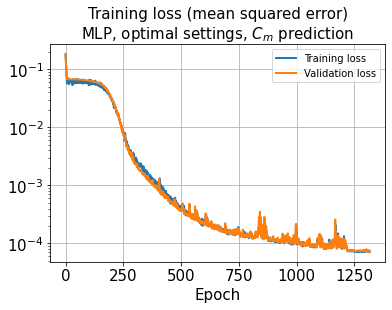

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

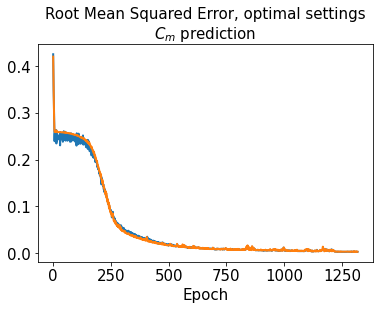

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

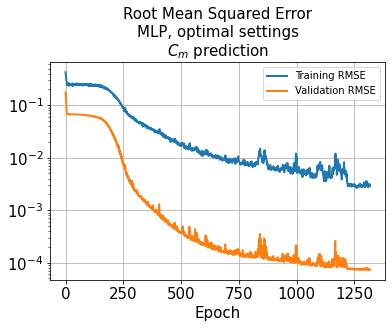

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

22/22 [==============================] - 0s 4ms/step - loss: 8.1095e-05 - rmse: 0.0037


In [35]:
val_results = model.evaluate(x_val, y_val)

7/7 [==============================] - 0s 4ms/step - loss: 8.2136e-05 - rmse: 0.0038


In [36]:
test_results = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 8.5337e-05 - rmse: 0.0042


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

4/4 [==============================] - 0s 2ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.008050168675626563
0.3589081454872352


In [44]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.007944121792075747
0.3596195382616708


In [45]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.00868330137461422
0.40005691293986567


In [46]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [47]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [48]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteadyValidation_MLP_Case13_WithParameters_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [49]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [53]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [54]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [55]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [56]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [57]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

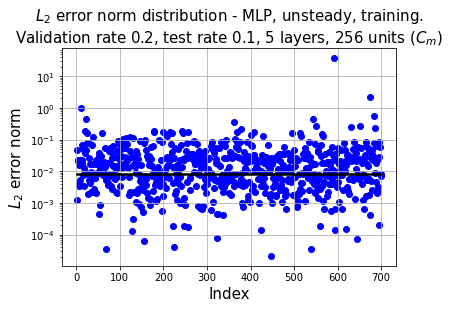

In [58]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

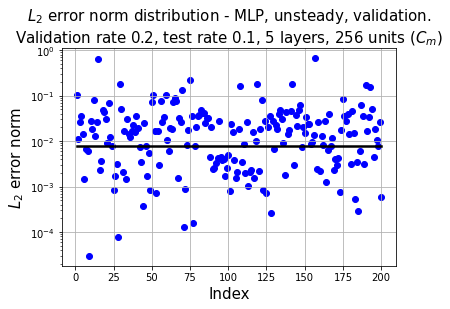

In [59]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

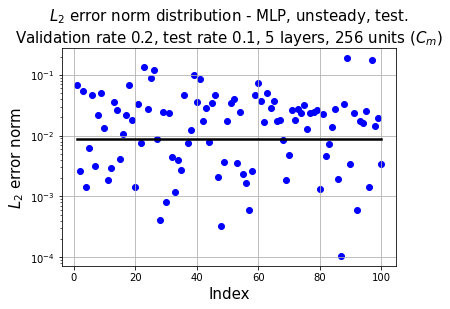

In [60]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [61]:
predicted = model.predict(x)

32/32 [==============================] - 0s 2ms/step


In [62]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [63]:
index_train.shape

(700,)

In [64]:
max(predicted)

array([1.0004165], dtype=float32)

In [65]:
l2_error(predicted, y)

0.008099452476439383

In [66]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [67]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [68]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [69]:
x[:,0] *= 5
x[:,0] += 10

L2 error of Cm: 0.0081


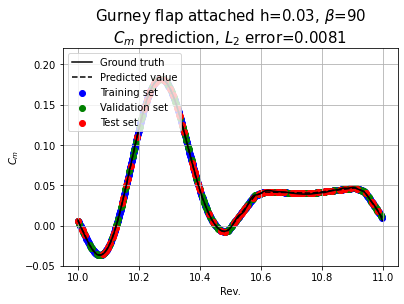

In [70]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [71]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0081


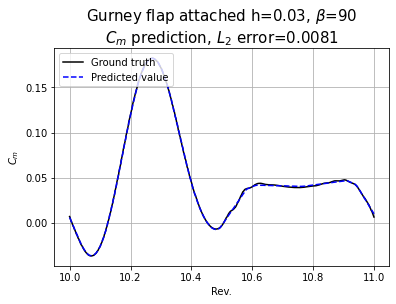

In [72]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0081


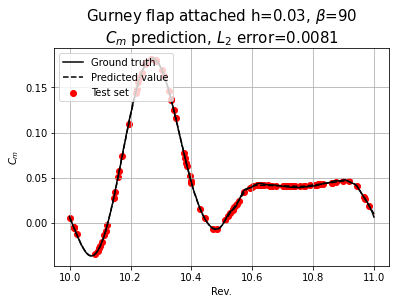

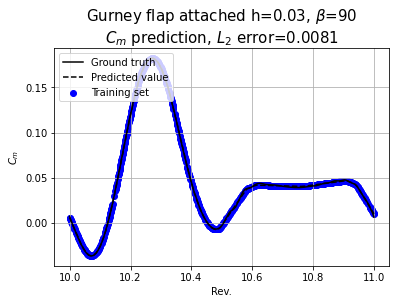

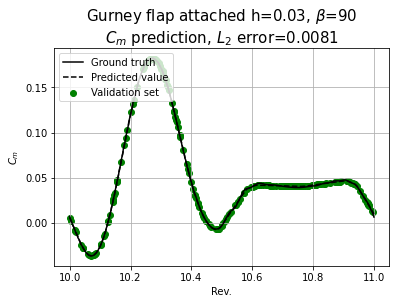

In [73]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()